<a href="https://colab.research.google.com/github/GitWahome/LBA-CS146/blob/master/LBA_MCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
ACCESS THE COLAB [THROUGH THIS LINK](https://colab.research.google.com/drive/1yhmSZ28bwlq1KLtpMMMYaE-sWov4Edx-?authuser=1)


---


IMPORTS

In [0]:
%matplotlib inline
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
#!pip install pystan
import pystan
import matplotlib.mlab as mlab
import math
from numpy.polynomial.polynomial import polyfit




---



---

# PRELIMINARY

---



---

I realize that a lot of what is beign done is data cleaning and transformations. I have included utilities to help you make inference of  my work. Here, I also made this indx to help you jump to the different secitons that answer the prompts.

Note:  I worked in collaboration with Sandie on the data cleaning and standardization. Inference and model fitting we individualized.

I apologize for such a long document. I have included massive headers to allow you to scroll fast into different sections. Basic descriptions of what I did in those sections is also included. I hope this will make it more convenient for you when evaluating this.

Hello. The first step I took was doing some manual cleaning of the data. This entailed a lot of things including standardization of the brands, locations, entries like 'no brand' and 'NA' to a standard 'No Brand' etc. I have stratified the data by location, product brand, store brand among others. These are available in the different CSVs I will make use of in the rest of the analysis. For now, I have included a summary of the main sheet to give you a glimpse of how the data looks post cleaning.

In [246]:
agg_responses = pd.read_csv("https://raw.githubusercontent.com/GitWahome/LBA-CS146/master/Copy%20of%20CS146%20LBA%20data%20gathering%20(Responses)%20-%20Form%20Responses%201.csv")
#print(agg_responses)
agg_responses.head()

,Locations,Grocery store Brand,Apple 1 Brand,Apple 1 price (€),Apple 2 Brand,Apple 2 price (€),Apple 3 Brand,Apple price (€),Banana 1 Brand,Banana 1 price (€),...,Eggs 2 Brand,Eggs 2 price (€),Eggs 3 Brand,Eggs 3 price (€),Chicken Breasts 1 Brand,Chicken Breasts 1 price (€),Chicken Breasts 2 Brand,Chicken Breasts 2 price (€),Chicken Breasts 3 Brand,Chicken Breasts 3 price (€)
0,Mitte,EDEKA,Granny Smith,1.99,Golden Deli,1.99,Braeburn,1.99,Bio,1.99,...,Gut & Gunstig,2.03,EDEKA,4.19,Le Gaulois,13.90,Friki,12.99,NaN,NaN
1,Friedrichshain,EDEKA,Bio,2.99,Kanzi,1.99,No Brand,1.99,Bio,1.99,...,EDEKA,5.98,Alnatura,6.58,Gut&Gunstig,6.48,Friki,8.90,Biofino,25.9
2,Mitte,ALDI,Pink Lady,2.99,No Brand,1.79,Etikett,1.39,Bio,1.29,...,No Brand,1.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Neukölln,Lidl,Apfel Rot,2.99,Apfel Rot,1.99,Pink Lady,2.49,No Brand,0.99,...,aus Bodenhaltung,1.98,Frusche Eier,1.69,Landjunker,6.29,NaN,NaN,NaN,NaN
4,Mitte,REWE,Talapfel Gale,1.95,GutBio,3.10,Snackapfel,1.90,REWE,1.65,...,Bodenhalttung,3.38,Freil weiss,2.82,REWE,8.67,GutBio,8.79,NaN,NaN





---



---

# DATA TRANSFORMATION: STACKING AND STRATIFICATION BY PRODUCT

---



---


For convenience, I separated the full dataset above by product and then amalgamated the prices keeping track of the respective brands, locations and Store Brand in one column. This  made it convenient for analysis.

In [0]:
##Stratification
Columns = list(agg_responses.columns.values)
apples =  agg_responses[Columns[:2]+Columns[2:8]]
bananas = agg_responses[Columns[:2]+Columns[8:14]]
Tomatoes = agg_responses[Columns[:2]+Columns[14:20]]
Potatoes = agg_responses[Columns[:2]+Columns[20:26]]
Flour = agg_responses[Columns[:2]+Columns[26:32]]
Rice = agg_responses[Columns[:2]+Columns[32:38]]
Milk = agg_responses[Columns[:2]+Columns[38:44]]
Butter = agg_responses[Columns[:2]+Columns[44:50]]
Eggs = agg_responses[Columns[:2]+Columns[50:56]]
Chicken_Breasts = agg_responses[Columns[:2]+Columns[56:62]]

In [248]:
#Stacking
Columns = list(apples.columns.values)
applesDf =pd.DataFrame({
    "Prices":list(apples[Columns[3]])+list(apples[Columns[5]])+list(apples[Columns[7]]),
    "ProductBrand": list(apples[Columns[2]])+list(apples[Columns[4]])+list(apples[Columns[6]]),
    "Store Brand":list(apples[Columns[1]])+list(apples[Columns[1]])+list(apples[Columns[1]]),
    "Geolocation":list(apples[Columns[0]])+list(apples[Columns[0]])+list(apples[Columns[0]])
})
Columns = list(bananas.columns.values)
bananasDf=pd.DataFrame({
    "Prices":list(bananas[Columns[3]])+list(bananas[Columns[5]])+list(bananas[Columns[7]]),
    "ProductBrand": list(bananas[Columns[2]])+list(bananas[Columns[4]])+list(bananas[Columns[6]]),
    "Store Brand":list(bananas[Columns[1]])+list(bananas[Columns[1]])+list(bananas[Columns[1]]),
    "Geolocation":list(bananas[Columns[0]])+list(bananas[Columns[0]])+list(bananas[Columns[0]])
})
Columns = list(Tomatoes.columns.values)
tomatoesDf=pd.DataFrame({
    "Prices":list(Tomatoes[Columns[3]])+list(Tomatoes[Columns[5]])+list(Tomatoes[Columns[7]]),
    "ProductBrand": list(Tomatoes[Columns[2]])+list(Tomatoes[Columns[4]])+list(Tomatoes[Columns[6]]),
    "Store Brand":list(Tomatoes[Columns[1]])+list(Tomatoes[Columns[1]])+list(Tomatoes[Columns[1]]),
    "Geolocation":list(Tomatoes[Columns[0]])+list(Tomatoes[Columns[0]])+list(Tomatoes[Columns[0]])
})
Columns = list(Potatoes.columns.values)
potatoesDf=pd.DataFrame({
    "Prices":list(Potatoes[Columns[3]])+list(Potatoes[Columns[5]])+list(Potatoes[Columns[7]]),
    "ProductBrand": list(Potatoes[Columns[2]])+list(Potatoes[Columns[4]])+list(Potatoes[Columns[6]]),
    "Store Brand":list(Potatoes[Columns[1]])+list(Potatoes[Columns[1]])+list(Potatoes[Columns[1]]),
    "Geolocation":list(Potatoes[Columns[0]])+list(Potatoes[Columns[0]])+list(Potatoes[Columns[0]])
})
Columns = list(Flour.columns.values)
flourDf=pd.DataFrame({
    "Prices":list(Flour[Columns[3]])+list(Flour[Columns[5]])+list(Flour[Columns[7]]),
    "ProductBrand": list(Flour[Columns[2]])+list(Flour[Columns[4]])+list(Flour[Columns[6]]),
    "Store Brand":list(Flour[Columns[1]])+list(Flour[Columns[1]])+list(Flour[Columns[1]]),
    "Geolocation":list(Flour[Columns[0]])+list(Flour[Columns[0]])+list(Flour[Columns[0]])
})
Columns = list(Rice.columns.values)
riceDf=pd.DataFrame({
    "Prices":list(Rice[Columns[3]])+list(Rice[Columns[5]])+list(Rice[Columns[7]]),
    "ProductBrand": list(Rice[Columns[2]])+list(Rice[Columns[4]])+list(Rice[Columns[6]]),
    "Store Brand":list(Rice[Columns[1]])+list(Rice[Columns[1]])+list(Rice[Columns[1]]),
    "Geolocation":list(Rice[Columns[0]])+list(Rice[Columns[0]])+list(Rice[Columns[0]])
})
Columns = list(Milk.columns.values)
milkDf=pd.DataFrame({
    "Prices":list(Milk[Columns[3]])+list(Milk[Columns[5]])+list(Milk[Columns[7]]),
    "ProductBrand": list(Milk[Columns[2]])+list(Milk[Columns[4]])+list(Milk[Columns[6]]),
    "Store Brand":list(Milk[Columns[1]])+list(Milk[Columns[1]])+list(Milk[Columns[1]]),
    "Geolocation":list(Milk[Columns[0]])+list(Milk[Columns[0]])+list(Milk[Columns[0]])
})

Columns = list(Butter.columns.values)
butterDf=pd.DataFrame({
    "Prices":list(Butter[Columns[3]])+list(Butter[Columns[5]])+list(Butter[Columns[7]]),
    "ProductBrand": list(Butter[Columns[2]])+list(Butter[Columns[4]])+list(Butter[Columns[6]]),
    "Store Brand":list(Butter[Columns[1]])+list(Butter[Columns[1]])+list(Butter[Columns[1]]),
    "Geolocation":list(Butter[Columns[0]])+list(Butter[Columns[0]])+list(Butter[Columns[0]])
})

Columns = list(Eggs.columns.values)
eggsDf=pd.DataFrame({
    "Prices":list(Eggs[Columns[3]])+list(Eggs[Columns[5]])+list(Eggs[Columns[7]]),
    "ProductBrand": list(Eggs[Columns[2]])+list(Eggs[Columns[4]])+list(Eggs[Columns[6]]),
    "Store Brand":list(Eggs[Columns[1]])+list(Eggs[Columns[1]])+list(Eggs[Columns[1]]),
    "Geolocation":list(Eggs[Columns[0]])+list(Eggs[Columns[0]])+list(Eggs[Columns[0]])
})
Columns = list(Chicken_Breasts.columns.values)
chicken_breastsDf=pd.DataFrame({
    "Prices":list(Chicken_Breasts[Columns[3]])+list(Chicken_Breasts[Columns[5]])+list(Chicken_Breasts[Columns[7]]),
    "ProductBrand": list(Chicken_Breasts[Columns[2]])+list(Chicken_Breasts[Columns[4]])+list(Chicken_Breasts[Columns[6]]),
    "Store Brand":list(Chicken_Breasts[Columns[1]])+list(Chicken_Breasts[Columns[1]])+list(Chicken_Breasts[Columns[1]]),
    "Geolocation":list(Chicken_Breasts[Columns[0]])+list(Chicken_Breasts[Columns[0]])+list(Chicken_Breasts[Columns[0]])
})

applesDf['ProductBrand'] = (applesDf['ProductBrand'] == "No Brand").astype(int)
bananasDf['ProductBrand'] = (bananasDf['ProductBrand'] == "No Brand").astype(int)
tomatoesDf['ProductBrand'] = (tomatoesDf['ProductBrand'] == "No Brand").astype(int)
potatoesDf['ProductBrand'] = (potatoesDf['ProductBrand'] == "No Brand").astype(int)
flourDf['ProductBrand'] = (flourDf['ProductBrand'] == "No Brand").astype(int)
riceDf['ProductBrand'] = (riceDf['ProductBrand'] == "No Brand").astype(int)
milkDf['ProductBrand'] = (milkDf['ProductBrand'] == "No Brand").astype(int)
butterDf['ProductBrand'] = (butterDf['ProductBrand'] == "No Brand").astype(int)
eggsDf['ProductBrand'] = (eggsDf['ProductBrand'] == "No Brand").astype(int)
chicken_breastsDf['ProductBrand'] = (chicken_breastsDf['ProductBrand'] == "No Brand").astype(int)
colCriteria = {
"Stores":list(set(applesDf["Store Brand"])),
"Products":set(["No Brand", "Branded"]),
"Location":set(applesDf["Geolocation"])
}
refCategorizer = {"Store Brand":"Stores","Geolocation":"Location","ProductBrand":"Products"}
applesDf.head()

,Geolocation,Prices,ProductBrand,Store Brand
0,Mitte,1.99,0,EDEKA
1,Friedrichshain,2.99,0,EDEKA
2,Mitte,2.99,0,ALDI
3,Neukölln,2.99,0,Lidl
4,Mitte,1.95,0,REWE





---



---

# REPLACING STRINGS WITH INTEGERS CATEGORIES

---



---

Working with text is a bit hectic. I thus came up with numbers to serve as categorical references as per the colCriteria above. 

In [0]:
def categories(factor, dataframe):   
  if factor is not 'Prices':
    factorlist =dict([(list(set(dataframe[factor]))[i], i+1)  
                   for i in range(len(set(dataframe[factor])))])
  return factorlist
def categoriesReplace(dataFrame):
  Columns = list(dataFrame.columns.values)
  for factorCol in Columns:
    if factorCol is not 'Prices':
      categDict = categories(factorCol, dataFrame)
      dataFrame[factorCol] = dataFrame[factorCol].map(categDict)
      #dataFrame[factorCol] = pd.Categorical(dataFrame[factorCol])
  return dataFrame

Having developed a mapping approach to the election data, I now need to transform it to a manner similar to the class code to facilitate reuse.

My first step was to create a stratifier to separate the data by factor. 





**Now here is where the fun stuff starts. For a start, this assignment was pretty much the diamond in my intellectual world. There is nothing I have encountered quite as hard as this. I am not sure if the approach I took is correct, but I will try and explain my thought process and justify my approach to the best of my ability. Hopefully it makes sense to you. Thank you.**

The price of each product was what the whole assignment tried to infer. While this was an oversimplification, the price was dictated by the following factors: 
Product brand, store brand and geographical location.

1.   Product Brand
2.   Store Brand 
3.   Geographic Location.




Having stratified the data by product, we can use this as our data. My assumption is that this price data is normally distributed per product per factor. I included a plotter but it is turned off by default to make things neater 

To find the multipliers, I would need to find the distribution of the prices by the various factors above.  I need to plot a distribution of data by product brand, store brand, geolocation.

This is quite a daunting task, or maybe I am overthinking it, but I will roll with it. So here is what I will do, I will start with the Store Brand. These are few. I want to use very general functions to maximize code reusability. As such, I will automate the fetching of the unique set of the data groups be it Store Brand,  Product Brand, Prices and Geolocation. I will then retrieve the matching product prices for each of the groups.



In [0]:
"""
The function below will print out how many unique factors there are. 
The most daunting of them was the Product Brands. 
Things like store Brands were easy to deal with since we had only 5 options or so. 
It prints out the length of the unique factor set and the various prices under the factor.
It also plots the prices for non empty datasets.
I assumed these to be normal distributions due to the nature of pricing. 
So I found the mean and variance and plotted them.
It returns a dictionary of the prices as per the unique factors.

I never stratified the brands in the case of product but I will do so in my analysis later
"""
#The plots can clutter the results so I set them to False by default.
#You can set plot to true to see the normal plots 

def uniqueFactor(FactorName, dataFrame, plot = False):
    uniqueCol= dataFrame[FactorName].unique().tolist()
    priceByFactor = {}
    if plot:
      print("There are a total of {} different values under the column {}\n".format(len(uniqueCol), FactorName))
      print("These are {}\n".format(uniqueCol))
      print("The plot below illustrates some of their assumed normal distributions")
    for uni in uniqueCol:
      data = dataFrame.loc[dataFrame[FactorName] == uni]#[["Prices", FactorName, "Geolocation", "S"]]
      priceByFactor[uni] = data
      if plot:
        if len(data["Prices"]) != 0:
          try:
            mu = np.mean(data["Prices"])
            variance = np.var(data["Prices"])
            sigma = math.sqrt(variance)
            x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            plt.title("Plot of prices for the various factors under {}".format(FactorName))
            plt.legend(loc='upper left')
            plt.plot(x,mlab.normpdf(x, mu, sigma), label = list(colCriteria[refCategorizer[FactorName]])[uni-1])
          except:
            pass
    if plot:
      plt.show()
    return priceByFactor


Now, here is an example of what the function above outputs

#Normal plots

I did not print the normals for each of the products by factor. I did this only for Apples. This can be toggled on and off by setting the plot argument of my unique factor to True. It also prints some metadata if you want to know more about what is going on.

There are a total of 9 different values under the column Geolocation

These are [3, 1, 9, 8, 5, 7, 4, 6, 2]

The plot below illustrates some of their assumed normal distributions


/usr/local/lib/python3.6/dist-packages/matplotlib/mlab.py:1544: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5 * (1./sigma*(x - mu))**2)


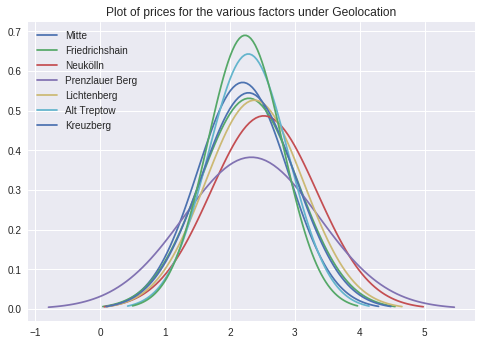

There are a total of 4 different values under the column Store Brand

These are [1, 3, 2, 4]

The plot below illustrates some of their assumed normal distributions


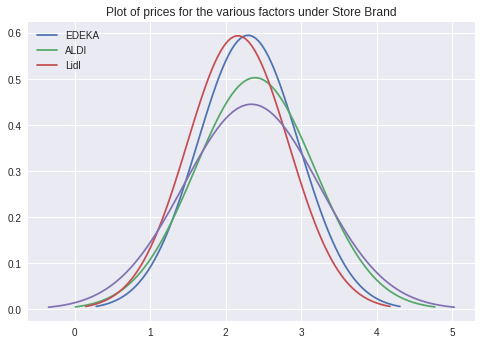

There are a total of 2 different values under the column ProductBrand

These are [1, 2]

The plot below illustrates some of their assumed normal distributions


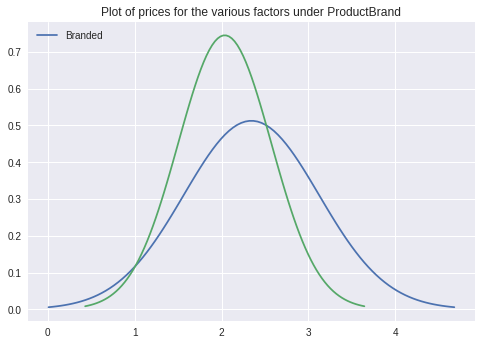

In [251]:
categApples = applesDf 
categApples = categoriesReplace(categApples)
categApples.head()

geo_apples = uniqueFactor("Geolocation", categApples, plot=True)
stores_apples = uniqueFactor("Store Brand", categApples,plot=True)
prod_apples = uniqueFactor("ProductBrand", categApples,plot=True)


The output above may not seem like much but it makes things extremely convenient in that we can retrieve the individual datasets per product per factor as stated this way:

Say we want all the prices of apples from LIDL, store 3 in our case from the categorizerdictionary: 

In [252]:
stores_apples[3].head()

,Geolocation,Prices,ProductBrand,Store Brand
2,3,2.99,1,3
8,5,3.74,1,3
9,3,0.79,1,3
10,5,1.79,1,3
11,7,1.89,1,3


Now let us structure our data as surves a survey .  This can be achieved by finding the average price for each store. 

In [0]:
categBananas = bananasDf 
categBananas = categoriesReplace(categBananas)

geo_bananas = uniqueFactor("Geolocation", categBananas)
stores_bananas = uniqueFactor("Store Brand", categBananas)
prod_bananas = uniqueFactor("ProductBrand", categBananas)

In [0]:
categTomatoes = tomatoesDf 
categTomatoes = categoriesReplace(categTomatoes)

geo_tomatoes = uniqueFactor("Geolocation", categTomatoes)
stores_tomatoes = uniqueFactor("Store Brand", categTomatoes)
prod_tomatoes = uniqueFactor("ProductBrand", categTomatoes)

In [0]:
categPotatoes = potatoesDf 
categPotatoes = categoriesReplace(categPotatoes)

geo_potatoes = uniqueFactor("Geolocation", categPotatoes)
stores_potatoes = uniqueFactor("Store Brand", categPotatoes)
prod_potatoes = uniqueFactor("ProductBrand", categPotatoes)


In [0]:
categFlour = flourDf 
categFlour = categoriesReplace(categFlour)

geo_flour = uniqueFactor("Geolocation", categFlour)
stores_flour = uniqueFactor("Store Brand", categFlour)
prod_flour = uniqueFactor("ProductBrand", categFlour)


In [0]:
categRice = riceDf 
categRice = categoriesReplace(categRice)

geo_rice = uniqueFactor("Geolocation", categRice)
stores_rice = uniqueFactor("Store Brand", categRice)
prod_rice = uniqueFactor("ProductBrand", categRice)

In [0]:
categMilk = milkDf 
categMilk = categoriesReplace(categMilk)

geo_milk = uniqueFactor("Geolocation", categMilk)
stores_milk = uniqueFactor("Store Brand", categMilk)
prod_milk = uniqueFactor("ProductBrand", categMilk)

In [0]:
categButter = butterDf 
categButter = categoriesReplace(categButter)

geo_butter = uniqueFactor("Geolocation", categButter)
stores_butter = uniqueFactor("Store Brand", categButter)
prod_butter = uniqueFactor("ProductBrand", categButter)


In [0]:
categEggs = eggsDf 
categEggs = categoriesReplace(categEggs)

geo_eggs = uniqueFactor("Geolocation", categEggs)
stores_eggs = uniqueFactor("Store Brand", categEggs)
prod_eggs = uniqueFactor("ProductBrand", categEggs)



In [0]:
categChicken_Breasts = chicken_breastsDf 
categChicken_Breasts = categoriesReplace(categChicken_Breasts)

geo_chicken_breasts = uniqueFactor("Geolocation", categChicken_Breasts)
stores_chicken_breasts = uniqueFactor("Store Brand", categChicken_Breasts)
prod_chicken_breasts = uniqueFactor("ProductBrand", categChicken_Breasts)



---



---

# DIMENSIONALITY REDUCTION BY INFERRING AVERAGES

---



---



Now to get averages from all data which will serve as the survey input.
I am going to reshape the inputs to be on a scale to 1. This has been achieved by setting an norm flag that activates interpolation. You can turn it off by setting it to 0 to work with the raw averages This will allow me to assign the same multiplier accross different products since the price they bear will be on a common scale.

In [0]:
#The data had 9 different geolocation, 4 different store brands and 2 different product brand categories, ''branded; and 'non branded', dumbified as 1 and 0 
#as a 'brand'. We will just correct this by ignoring It multiplier and setting it to 1
numGeo, numStore,numProd = 9, 4, 2
stores = []
products = [prod_apples,prod_bananas, prod_tomatoes,prod_potatoes,prod_flour,prod_rice,
            prod_milk,prod_butter,prod_eggs,prod_chicken_breasts]
stores = [stores_apples,stores_bananas, stores_tomatoes,stores_potatoes,stores_flour,stores_rice,
            stores_milk,stores_butter,stores_eggs,stores_chicken_breasts]

geo = [geo_apples,geo_bananas, geo_tomatoes,geo_potatoes,geo_flour,geo_flour,geo_rice,
            geo_milk,geo_butter,geo_eggs,geo_chicken_breasts]

def survey_gen(numFacs,dataSet):
  averages = []
  for factor in range(1,numFacs+1):
      averages.append(np.average(dataSet[factor].dropna()["Prices"]))
  return np.array(averages),np.array(np.round(np.array(averages)/np.sum(averages), 2)*100).astype(int)

def survey_iter(numFac,fullData, norm = 1):
  finalSurvey = []
  for dataSet in fullData:
    finalSurvey.append(survey_gen(numFac,dataSet)[norm])
  return np.array(finalSurvey)
main_data = {
    "Products":survey_iter(numProd,  products, norm = 1),
    "Location":survey_iter(numGeo,  geo, norm = 1),
    "Stores":survey_iter(numStore,  stores, norm = 1)
}
raw_data = {
    "Products":survey_iter(numProd,  products, norm = 0),
    "Location":survey_iter(numGeo,  geo, norm = 0),
    "Stores":survey_iter(numStore,  stores, norm = 0)
}



---



---

# STAN MODEL

---



---


Now that I have pretty much full stratification and a dimensionality reduction after splitting the prices by the affecting factors, let us begin the deep analysis using stan.


In [263]:
stan_code = '''
data {
    int S;  // Number of surveys: I will have this as 1 since we had just one result set for each data by factor
    int C;  // This will be the number of unique factors eg for stores, we have EDEKA, Lidl, Aldi and Rewe
    int survey_results[S, C];  //Price information for the various factors
    real cauchy_location;  // Prior for Cauchy over alpha : A prior for our multipliers distribution
    real cauchy_scale; 
}

parameters {
    vector<lower=0>[C] alpha;
    simplex[C] p[S];  // One probability vector for each 'survey', in our case, each product price data
}

model {
    alpha ~ cauchy(cauchy_location, cauchy_scale);
    for (i in 1:S) {
        p[i] ~ dirichlet(alpha);
        survey_results[i] ~ multinomial(p[i]);
    }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d80525d69dcaf085f25008797ff803dc NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp4au16wse/stanfit4anon_model_d80525d69dcaf085f25008797ff803dc_1648397554931427621.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)




---



---

# DISCUSSION: Why the model Choices and intuition.

---



---



Here, I plot the various posterior distributions by products. To infer the posterior multiplier, I evaluated the ratio of the sample mean to the overall mean by product. This gives me a value centered at 1 that essentially captures the distortion relative to average. Note, the modelled data values were transformations. I wanted them in the range 0-1 so I divided everything by the total of the dataset. This was in line with the flip perspective I rolled with from above where I am modelling the chance that a given price will be made as per a given set of factors and subfactors. 

To facilitate class code reuse, I multiplied them by 100 after rounding the proportions to the nearest 2dp . This gave me integers that allowed me to scale the  survey_results vector similarly to the election data results like we did in class. I did this multiplication because I needed integers to keep consistent with the type declaration. Later on, I divide them by 100 again to get my proportions back. 

The multipliers were implied by the proportions of the prices thus a prior for the price proportions is inherently the prior for my multipliers.

The posterior is the disribution of these chances of prices being charged by a store after we update the beliefs initiated by our prior given our data. I made use of a cauchy prior since I did not know the variance and expected value of the implied multipliers or the proportions themselves. Due to this, I needed it to be broad but centered around 1 thus the 1 location parameter. 


**My choice too go with the multinomial likelihood explained:**

Given that I am thinking of chances of a price being for the different factors, I can think of this as trials.  The proportion of the  price average dictated by a factor is the chance of victory for that specific factor. 1-the proportion is the chance of loss, which is basically the chance that the price is dictated by the set of other factors. I though of the set up as being composed of **bernoulli tests where at each level we are looking at the probability of a given price being made by a specific factor**. from price charges. Given that we had multiple tests, it would only make sense to roll with a multinomial distribution.

**DIrichlet distribution**
I had too few surveys to generalzie the findings. I took inspiration from the election modelling again and used a dirichlet distriubution as a probability vector of the price proportions fed into my system. This gives me a probability distribution of simulated number of trials(ns) and price proportions(p) which I used as the parameters of my likelihood function. This is basically what was done in class and since I was trying to map my system directly, I figured it would still hold in my context especially if I made the data fed into the model dynamic.

**Multinomial distribution**

I also limited the outcomes to being binomial as per the stated criteria above.  I could have rolled with a binomial likelihood for brand data but given that some factors had more than 2 possible outcomes, eg stores where there were 4 stores to consider, I thus went with the multinomial. A binomial can afterall be though of a multinomial with only 2 possible outcomes.

**Assumption**
I made the assumption that each price proportion is independent of the rest. This is essentially saying the  price the market assigns a given factor subfactor is independent of the rest. While this is arguable, it is necessary for simplification.
.

**Acknowledgement**

At this point, I want to acknowledge that thinking of price proportions as a probabilities is a bit of a fetch. I hope you consider my thought process too though and I would appreciate the feedback. This assignmment was extremely hard and I had to think through something that made any bit of sense and given the market argument, I could see how it made sense to see this system set up as vote surveys. 



**TLDR: Further atttempt to justify this set up as an election survey system: I also used this as a fallback to remind myself what I am doing**

So with prices being influenced by the market, which is essentially the people. one can think of the prices people make the stores charge them through supply and demand as sort of votes. It does not directly translate to the value obtained being the probability of a user buying a product at the specified price like the election data outcome where the ouput was the chance a user would vote for the specified candidate. What it gives us is a proportion of the market price that the various products, location etc end up influencing relative to similarly pooled factors. Example, the proportion of the average price that Aldi prices dictate, the proportion of the same that Edeka prices dictate among others. In this regard, you can interprete the probability distribution of the price data proportions as the probability that the amount you paid is influenced by Edeka, or a location or a brand. So if I had a price factor of 0.4 for Edeka, If I end up paying 2.5eu, there ia 40% contribution to the price by Edeka. It is a bit far fetched, I know and totally understand if I end up with punishment because of this. But I rolled with it and did a back inference to try and see how the relative influence these different groups have compared to the average influence that a store would have. This would entail sampling from the posteriors, finding the mean of the samples, then expressing it as a ratio to the average price as per say the store, also expressed as a proportion. The values for different stores would center around the proportion of their average to the global average and this would be 1. Multiplying the individual product/brand/location multiplier would give you the expected price you would pay if you bought a product influenced by those criteria. 

**SIMULATION DATA: POSTERIOR SAMPLING AND MULTIPLIER INFERENCE**

Below you will find plots of the posterior samples by product, by factor, by subfactor. You will also see the multipliers listed and the confidence intervals.

Our columns
{'Stores': ['EDEKA', 'Lidl', 'ALDI', 'REWE'], 'Products': {'Branded', 'No Brand'}, 'Location': {'Friedrichshain', 'Schöneberg', 'Mitte', 'Alt Treptow', 'Lichtenberg', 'Kreuzberg', 'Tempelhof', 'Prenzlauer Berg', 'Neukölln'}}
Posterior α samples and 95% confidence intervals for each Factor

*************************************************START OF Location ANALYSIS**********************************************************
{'S': 11, 'C': 9, 'survey_results': array([[11, 11, 11, 11, 12, 11,  9, 11, 12],
       [12, 11, 11, 10, 10, 12, 10, 11, 11],
       [14, 10, 13, 11, 11, 13,  6, 12, 10],
       [ 8, 10,  9, 12,  9,  8, 20,  9, 13],
       [10,  8, 13, 15,  9, 16,  4, 10, 15],
       [10,  8, 13, 15,  9, 16,  4, 10, 15],
       [14, 12, 13, 10,  7, 12,  9, 13,  9],
       [11, 11, 12, 11,  9, 12,  9, 14, 11],
       [12, 10, 11, 11, 15, 11, 10, 10, 11],
       [13, 12, 13, 11, 10, 13,  6, 13, 10],
       [13, 10, 13, 10,  9, 12, 15, 10,  8]]), 'cauchy_location': 1, 'cauchy_

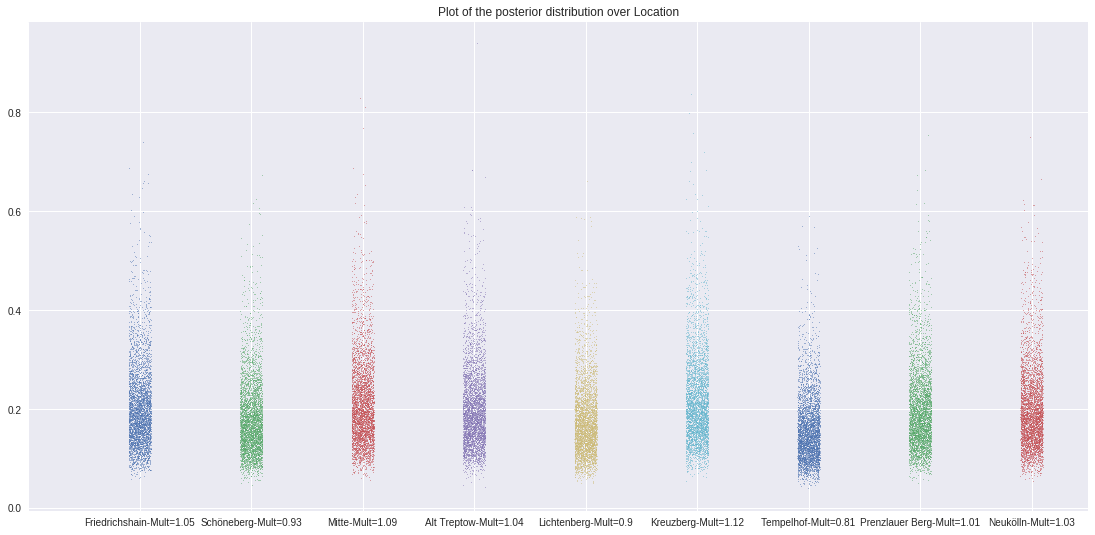

*************************************************END OF Location ANALYSIS


**************************************************
*************************************************START OF Products ANALYSIS**********************************************************
{'S': 10, 'C': 2, 'survey_results': array([[53, 47],
       [60, 40],
       [60, 40],
       [51, 49],
       [50, 50],
       [59, 41],
       [51, 49],
       [52, 48],
       [55, 45],
       [44, 56]]), 'cauchy_location': 1, 'cauchy_scale': 1}


Products
Mean of the samples [0.30756863372753374, 0.267525244473361]
The overall mean of the Products samples is 0.28754693910044704
#############################################################################################

#############################################################################################

These are the 95% confidence intervals 



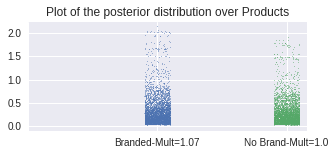

*************************************************END OF Products ANALYSIS


**************************************************
*************************************************START OF Stores ANALYSIS**********************************************************
{'S': 10, 'C': 4, 'survey_results': array([[25, 24, 26, 25],
       [28, 22, 23, 26],
       [27, 24, 23, 26],
       [26, 25, 25, 24],
       [26, 22, 21, 32],
       [35, 16, 16, 33],
       [27, 24, 22, 27],
       [25, 25, 28, 22],
       [31, 20, 21, 28],
       [31, 15, 23, 31]]), 'cauchy_location': 1, 'cauchy_scale': 1}


Stores
Mean of the samples [0.3790839494892532, 0.29192349816185814, 0.3085787330568361, 0.3704509113221844]
The overall mean of the Stores samples is 0.3375092730075323
#############################################################################################

#############################################################################################

These are the 95% confidence intervals 



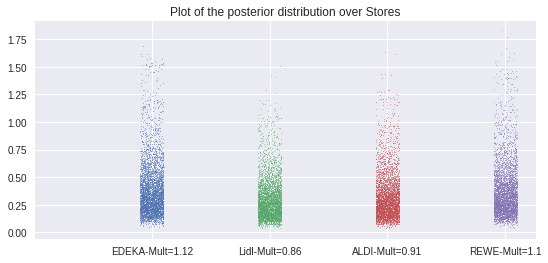

*************************************************END OF Stores ANALYSIS


**************************************************


In [273]:
print("Our columns")
print(colCriteria)
print('Posterior α samples and 95% confidence intervals for each Factor\n')
multipliers = {"Products":{}, "Location":{}, "Stores":{}}
results = {}
applesFactors = categApples
factors = sorted(main_data.keys())
for factor in factors:
    print("*************************************************{} {} {}**********************************************************".format("START OF",factor,"ANALYSIS"))
    data = {
        'S': len(main_data[factor]),
        'C': len(main_data[factor][0]),
        'survey_results': main_data[factor],
        'cauchy_location': 1,
        'cauchy_scale': 1
    }
    #print(data)
    results[factor] = stan_model.sampling(data=data)
    samples = results[factor].extract()
    # Divide them by 100 to counter the 100 division we did to make it work with the class model
    samples["alpha"] /=100.0
    print(factor)
    confints = np.percentile(samples['alpha'], [2.5, 97.5], axis=0)
    means = list(np.average(samples['alpha'], axis=0))
    overall = np.average(samples['alpha'])
    multips = [np.round(list(means/overall)[i], 2)  for i in range(len(colCriteria[factor]))]
    multipliers[factor] = dict([(list(colCriteria[factor])[i],multips[i]) for i in range(len(multips))])
    print("Mean of the samples {}".format(means))
    print("The overall mean of the {} samples is {}".format(factor,overall))
    print("#############################################################################################\n")
    combo =   ["{}-Mult={}".format(list(colCriteria[factor])[i], np.round(list(means/overall)[i], 2))  for i in range(len(colCriteria[factor]))]
    if factor == "Products":
      multipliers[factor]["No Brand"] = 1.0
      combo[1] = "No Brand-Mult=1.0"
    print("#############################################################################################\n")
    print("These are the 95% confidence intervals \n")
    confInts = pd.DataFrame(dict(list(enumerate(zip(confints[0],confints[1])))))
    confInts.head()
    plt.figure(figsize=(1+len(main_data[factor][0])*2,len(main_data[factor][0])))
    for i in range(len(main_data[factor][0])):
        plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000), samples['alpha'][:,i], ',', alpha=0.5)
        plt.title("Plot of the posterior distribution over {}".format(factor))
        plt.xticks(range(len(main_data[factor][0])+1), [""]+list(combo))
    plt.show()
    print("*************************************************{} {} {}**************************************************".format("END OF",factor,"ANALYSIS\n\n\n"))




---


---

# UTILITIES FOR INFERENCE

---



---



I also created this function to give you a final price given the product brand.

**UTILITY FORM: INPUT YOUR DATA TO GET AN EXPECTED PRICE ESTIMATE**

In [275]:
#@title Enter the following data to get a price estimate { vertical-output: true, form-width: "50%" }
store = "REWE" #@param ["ALDI", "Lidl", "REWE", "EDEKA"]
product = "eggs" #@param ["apples", "bananas", "flour", "rice", "milk", "butter", "eggs", "chicken breasts", "tomatoes", "potatoes"]
location = "Prenzlauer Berg" #@param ["Alt Treptow", "Friedrichshain", "Kreuzberg", "Lichtenberg", "Mitte", "Neuk\xF6lln", "Prenzlauer Berg", "Sch\xF6neberg", "Tempelhof"]
brand = "Branded" #@param ["No Brand", "Branded"]
def priceGen(brand, store, location, product):
  if location == "Neuk\\xF6lln":
    location ="Neukölln"
  if location == "Sch\\xF6neberg":
    location ="Schöneberg"
  
  product = product.lower()
  #I realized I must have failed to fix this and thus would mess my reference thus I just overwrote it here
  if brand == "No Brand":
    brandMult = 1.0
  else:
    brandMult = multipliers["Products"][brand]
  locMult = multipliers["Location"][location]
  storeMult = multipliers["Stores"][store]
  proDict = {"apples":0,"bananas":1,"tomatoes":2,"potatoes":3,"flour":4,"rice":5,"milk":6,
             "butter":7,"eggs":8,"chicken breasts":9}
  
  prodId = proDict[product]
  print(raw_data["Products"][0])
  avgPrice = np.average([np.average(raw_data["Products"][prodId], axis = 0), np.average(raw_data["Location"][prodId],axis = 0), np.average(raw_data["Stores"][prodId], axis = 0)])
  print("Multipliers you will use BRAND: {} LOCATION: {} STORE: {}".format(brandMult, locMult, storeMult))
  print("Average price for 1kg of {} is {} ".format(product,avgPrice))
  return "Expected price for your 1KG of {} {} at the {} store located in {} is {}.".format(brand, product,store,location, brandMult*locMult*storeMult * avgPrice )

priceGen(brand, store, location, product)

[2.34391566 2.03730769]
Multipliers you will use BRAND: 1.07 LOCATION: 1.01 STORE: 1.1
Average price for 1kg of eggs is 3.1230598433439396 


'Expected price for your 1KG of Branded eggs at the REWE store located in Prenzlauer Berg is 3.7125998499719755.'

**Basic Average Price For each Product (I just retrieved this from the form above):**

*   RICE: 2.25242474083951 
*   BANANAS: 1.4685830109526368
*   TOMATOES: 3.3606291735715548 
*   POTATOES: 1.4674559681668156 
*   FLOUR: 1.0987810607879889
*   RICE: 1.883569146193177
*   MILK:  1.4870632589487078 
*   BUTTER: 3.0772333033000243 
*  EGGS: 3.1230598433439396 
*   CHICKEN BREASTS : 8.283421359555492 



**Magnitude of effect by brand, grocery store and Geographical Location.**

To answer this, I just printed out the multipliers dictionary and included mapped it to the product ID/Store ID among others. It is inbuilt in the Utility form above.

Products multipliers: The individual product brand affects the data as follows:

In [278]:
#@title Select a factor to see how much it affects the price { vertical-output: true, form-width: "50%" }
factor = "Location" #@param ["Location", "Stores", "Products"]
def multiPrinter(factor):
  multiData = pd.DataFrame(multipliers)
  multiData
  return multiData.loc[multiData[factor].notnull()][[factor]]
 
  
multiPrinter(factor)

,Location
Alt Treptow,1.04
Friedrichshain,1.05
Kreuzberg,1.12
Lichtenberg,0.90
Mitte,1.09
Neukölln,1.03
Prenzlauer Berg,1.01
Schöneberg,0.93
Tempelhof,0.81


Toggle the factor effect utility above for the magnitude of effect of the different factors and the several factor groups within them. The magnitude of effect is relative to 1: If it is greater than 1, it increases the price by a proportion equivalent to the multiplier. If less, it reduced it by the same factor.


**Does the price variation by Geographical location correlate witht he variation in rental prices in Berlin or not?**

YES!!! I was not so sure my results made sense until I did this analysis and the correlation is amazing! Mitte by the way is a broad area encompassing a number of districts so for Its price, I sampled from some of the areas within it to get the price.

I went ahead and multipled my multipliers by the average price of the houses in the regions we were considering.

In [105]:
truePrices = [794, 774, 844,739,902,812,856,792,755]
locMult = multiPrinter("Location")
locMult["Estimated Location Price(Euros)"] = np.round(locMult["Location"]*np.average(truePrices)*0.88,0).astype(int)
locMult["Actual Location Price(Euros)"] = truePrices
locMult

,Location,Estimated Location Price(Euros),Actual Location Price(Euros)
Alt Treptow,1.05,746,794
Friedrichshain,1.05,746,774
Kreuzberg,1.12,796,844
Lichtenberg,0.91,647,739
Mitte,1.09,775,902
Neukölln,1.03,732,812
Prenzlauer Berg,1.01,718,856
Schöneberg,0.93,661,792
Tempelhof,0.81,576,755


While they do not match up exactly, there is indeed a correlation. This scatterplot demonstrates this:

There is clearly a positive correlation


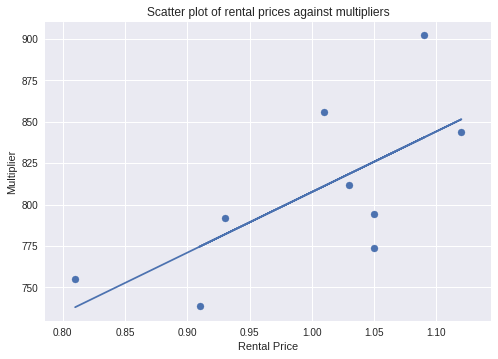

In [115]:
plt.scatter(locMult["Location"], truePrices)
plt.xlabel("Rental Price")
plt.ylabel("Multiplier")
b, m = polyfit(locMult["Location"], truePrices, 1)
plt.plot(locMult["Location"], b + m *locMult["Location"] , '-')
plt.title("Scatter plot of rental prices against multipliers")
print("There is clearly a positive correlation")



---



---

# METADATA

---



---



###[ALDI: Invalidenstraße 59, 17:30, 11/06/2018]
![ALDI: Invalidenstraße 59, 17:30, 11/06/2018](https://raw.githubusercontent.com/GitWahome/LBA-CS146/master/AldiInvaliden.png)


---

###[REWE: Schonhauser Allee 36-39, 10:00, 11/8/2018]
![REWE: Schonhauser Allee 36-39, 10:00, 11/8/2018](https://raw.githubusercontent.com/GitWahome/LBA-CS146/master/Rewe.png)



---



---


# THE END. Danke Schoen


---



---

